In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-data/sample_submission.csv
/kaggle/input/fraud-data/test_identity.csv
/kaggle/input/fraud-data/train_identity.csv
/kaggle/input/fraud-data/test_transaction.csv
/kaggle/input/fraud-data/train_transaction.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# IMPORTS

In [3]:
!pip install dagshub mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 54.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 64.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import resample
import shap
import dagshub
from sklearn.base import clone as sk_clone
from sklearn.tree import DecisionTreeClassifier

In [5]:
dagshub.init(repo_owner='gkuch22', repo_name='ml-hw2-gkuch22', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=208438a5-4315-49e2-a976-aca7fd8cb72b&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=8296e7fecffaab4ba2656114cfab3ef52620f476369da866688fe4ea04576a9b




Accessing as gkuch22

Initialized MLflow to track repo "gkuch22/ml-hw2-gkuch22"

Repository gkuch22/ml-hw2-gkuch22 initialized!

# DATA INSPECTION

In [6]:
df_transaction = pd.read_csv('/kaggle/input/fraud-data/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/fraud-data/train_identity.csv')
df_transaction.shape, df_identity.shape

((590540, 394), (144233, 41))

# DATA MERGE

In [7]:
df_transaction['key_id'] = (
    df_transaction['card1'].astype(str) + '_' +
    df_transaction['addr1'].astype(str) + '_' +
    df_transaction['P_emaildomain'].astype(str)
)
df = df_transaction.merge(df_identity, how='left', on='TransactionID')

In [8]:
df.shape

(590540, 435)

In [9]:
df['key_id'].nunique()

90375

# UNDER SAMPLING

In [10]:
df.shape

(590540, 435)

In [11]:
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]

non_fraud_undersampled = resample(non_fraud_df, replace=False, n_samples=3*len(fraud_df), random_state=42)

df_undersampled = pd.concat([fraud_df, non_fraud_undersampled])

df = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
fraud_df.shape

(20663, 435)

In [13]:
df.shape

(82652, 435)

# DATA SPLIT

In [14]:
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_valid_idx, test_idx = next(gss1.split(df, groups=df['key_id']))

train_valid_df = df.iloc[train_valid_idx]
test_df = df.iloc[test_idx]

gss2 = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_idx, valid_idx = next(gss2.split(train_valid_df, groups=train_valid_df['key_id']))

train_df = train_valid_df.iloc[train_idx]
valid_df = train_valid_df.iloc[valid_idx]

X_train = train_df.drop(columns='isFraud')
y_train = train_df['isFraud']

X_valid = valid_df.drop(columns='isFraud')
y_valid = valid_df['isFraud']

X_test = test_df.drop(columns='isFraud')
y_test = test_df['isFraud']

In [15]:
X_train.shape, X_valid.shape, X_test.shape

((48455, 434), (17381, 434), (16816, 434))

In [16]:
X_train

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,key_id,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
2,3268454,6875600,117.000,W,9592,532.0,150.0,mastercard,224.0,debit,143.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,8.0,1.0,524.0,524.0,175.0,524.0,175.0,NaN,NaN,NaN,NaN,210.0,NaN,NaN,NaN,NaN,454.0,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9592_143.0_hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3231066,5

# DATA CLEANING

In [17]:
class CustomNuniqueHandlerClass(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1):
        self.threshold = threshold
        self.drop_cols = []
        
    def fit(self, X, y):
        for col in X.columns:
            value_counts = X[col].value_counts(normalize=True)
            
            if value_counts.iloc[0] > self.threshold:
                self.drop_cols.append(col)

        return self
    
    def transform(self, X):
        cols_to_drop = [col for col in self.drop_cols if col in X.columns]
        return X.drop(columns=cols_to_drop)
    

In [18]:
class CustomMajorNanHandlerClass(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.drop_cols = []

    def fit(self, X, y):
        self.drop_cols = [col for col in X.columns if X[col].isna().mean() > self.threshold]
        return self
    
    def transform(self, X):
        cols_to_drop = [col for col in self.drop_cols if col in X.columns]
        return X.drop(columns=cols_to_drop)

In [19]:
cleaning_pipeline = Pipeline(steps=[
    ('nunique_handler', CustomNuniqueHandlerClass(threshold=0.9)),
    ('nan_handler', CustomMajorNanHandlerClass(threshold=0.9))
])

In [20]:
X_cleaned = cleaning_pipeline.fit_transform(X_train, y_train)

In [21]:
print("before:", X_train.shape)
print("after:", X_cleaned.shape)

before: (48455, 434)
after: (48455, 311)


In [22]:
# experiment_name = "Decision_Tree_Training"
# run_name = "Decision_Tree_Cleaning"

# import mlflow

# mlflow.set_experiment(experiment_name)

# with mlflow.start_run(run_name=run_name):

#     mlflow.log_param("nunique_threshold", 0.9)
#     mlflow.log_param("nan_threshold", 0.9)
    
#     cleaning_pipeline.fit(X_train, y_train)

#     mlflow.sklearn.log_model(cleaning_pipeline, "cleaning_pipeline")

# DATA ENGINEERING

In [23]:
class CustomCategoricalEncoderClass(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, encoder):
        self.threshold = threshold
        self.encoder = encoder
        self.cols = []
    
    def fit(self, X, y):
        self._encoder = clone(self.encoder)

        self.cols = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique() <= self.threshold]

        if self.cols:
            self._encoder.fit(X[self.cols])
        
        return self
    
    def transform(self, X):
        X = X.copy()
                
        if not self.cols:
            return X

        encoded = self._encoder.transform(X[self.cols])
        encoded_df = pd.DataFrame(
            encoded,
            index=X.index,
            columns=self._encoder.get_feature_names_out(self.cols)
        )
        
        X = X.drop(columns=self.cols)
        return pd.concat([X, encoded_df], axis=1)


In [24]:
class CustomWoeEncoderClass(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.target_col = target_col
        self.cat_columns = []
        self.woe_mappings = {}
        
    def fit(self, X, y):
        df = X.copy()
        df[self.target_col] = y

        self.cat_columns = [col for col in df.columns if df[col].dtype == 'object']

        for col in self.cat_columns:
            groups = df.groupby([col])[self.target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            with np.errstate(divide='ignore', invalid='ignore'):
                groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            
            self.woe_mappings[col] = woe_dict
                    
        return self
        
    
    def transform(self, X):
        df = X.copy()
        for col in self.cat_columns:
            mapping = self.woe_mappings.get(col)
            df[f"{col}_woe"] = df[col].map(mapping).fillna(0)
        return df.drop(columns=[col for col in self.cat_columns if col in df.columns], errors='ignore')
    

In [25]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

engineering_pipeline = Pipeline(steps=[
    ('onehot_encoder', CustomCategoricalEncoderClass(threshold=5, encoder=encoder)),
    ('woe_encoder', CustomWoeEncoderClass('isFraud')),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [26]:
X_engineered = engineering_pipeline.fit_transform(X_cleaned, y_train)
print("before:", X_cleaned.shape)
print("after:", X_engineered.shape)

before: (48455, 311)
after: (48455, 363)


In [27]:
# experiment_name = "Decision_Tree_Training"
# run_name = "Decision_Tree_Engineering"

# import mlflow

# mlflow.set_experiment(experiment_name)

# with mlflow.start_run(run_name=run_name):

#     mlflow.log_param("categorical_threshold", 5)
#     mlflow.log_param("onehot_encoder", "OneHotEncoder")
#     mlflow.log_param("woe_encoder", "WoeEncoder")
#     mlflow.log_param("imputer_strategy", "mean")
#     mlflow.log_param("scaler", "standard")
    
#     engineering_pipeline.fit(X_train, y_train)

#     mlflow.sklearn.log_model(engineering_pipeline, "engineering_pipeline")

# TRAINING

In [43]:
import mlflow
from sklearn.base import clone as sk_clone
from sklearn.tree import DecisionTreeClassifier
from itertools import product

logged_model = 'runs:/582efd80ff784537ac9bb1899d586167/cleaning_pipeline'
cleaning = mlflow.sklearn.load_model(logged_model)

logged_model = 'runs:/f5cd3ddfd3424719967852382ccce82c/engineering_pipeline'
engineering = mlflow.sklearn.load_model(logged_model)

nunique_thresholds = [0.8]
nan_thresholds = [0.8]
onehot_thresholds = [4]
imputers = ['mean']
scalers = {'standard': StandardScaler()}

max_depths = [8]
min_samples_splits = [7]
criterions = ['gini', 'entropy']

best_pipeline = None
best_roc_auc = 0
best_params = None

for uniquet in nunique_thresholds:
    for nant in nan_thresholds:
        for oht in onehot_thresholds:
            for imputer in imputers:
                for scaler_name, scaler in scalers.items():
                    for md, mss, crit in product(max_depths, min_samples_splits, criterions):
                        print()
                        print(f'uniquet={uniquet}, nt={nant}, oht={oht}, imputer={imputer}, scaler={scaler_name}')
                        print(f'md={md}, mss={mss}, crit={crit}')
                        
                        cleaning_pipeline = sk_clone(cleaning)
                        engineering_pipeline = sk_clone(engineering)
                        
                        cleaning_pipeline.named_steps['nunique_handler'].threshold = uniquet
                        cleaning_pipeline.named_steps['nan_handler'].threshold = nant
    
                        engineering_pipeline.named_steps['onehot_encoder'].threshold = oht
                        engineering_pipeline.named_steps['imputer'].strategy = imputer

                        model = DecisionTreeClassifier(max_depth=md, min_samples_split=mss,
                                                      criterion=crit, random_state=42) 
                        
                        pipeline = Pipeline(steps=[
                            ('cleaning', cleaning_pipeline),
                            ('engineering', engineering_pipeline),
                            ('model', model)
                        ])
                        
                        pipeline.fit(X_train, y_train)
                        
                        y_train_pred = pipeline.predict(X_train)
                        y_train_prob = pipeline.predict_proba(X_train)[:, 1]
                        
                        train_roc_auc = roc_auc_score(y_train, y_train_prob)
                        train_f1 = f1_score(y_train, y_train_pred)
                        print("TRAIN")
                        print(f"ROC AUC Score: {train_roc_auc}")
                        print(f"F1 Score: {train_f1}")
                        
                        
                        y_valid_pred = pipeline.predict(X_valid)
                        y_valid_prob = pipeline.predict_proba(X_valid)[:, 1]
                        
                        valid_roc_auc = roc_auc_score(y_valid, y_valid_prob)
                        valid_f1 = f1_score(y_valid, y_valid_pred)
                        print("VALID")
                        print(f"ROC AUC Score: {valid_roc_auc}")
                        print(f"F1 Score: {valid_f1}")
    
                        if valid_roc_auc > best_roc_auc:
                            best_roc_auc = valid_roc_auc
                            best_pipeline = pipeline
                            best_params = (uniquet, nant, oht, imputer, scaler_name, md, mss, crit)

print()
print("-------------------------")
print("TEST")
print("best params:", best_params)
y_test_pred = best_pipeline.predict(X_test)
y_test_prob = best_pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_test_prob)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"ROC AUC Score: {roc_auc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



uniquet=0.8, nt=0.8, oht=4, imputer=mean, scaler=standard
md=8, mss=7, crit=gini
TRAIN
ROC AUC Score: 0.8953793176948288
F1 Score: 0.7268085106382979
VALID
ROC AUC Score: 0.80296174571426
F1 Score: 0.5388429752066116

uniquet=0.8, nt=0.8, oht=4, imputer=mean, scaler=standard
md=8, mss=7, crit=entropy
TRAIN
ROC AUC Score: 0.9025731266180339
F1 Score: 0.7285707486554662
VALID
ROC AUC Score: 0.798831903496279
F1 Score: 0.5192192192192192

-------------------------
TEST
best params: (0.8, 0.8, 4, 'mean', 'standard', 8, 7, 'gini')
ROC AUC Score: 0.8231356254126903
Accuracy: 0.8393196955280685
Precision: 0.902334444973797
Recall: 0.43133682532452744
F1 Score: 0.5836671802773498


# ANALYSIS

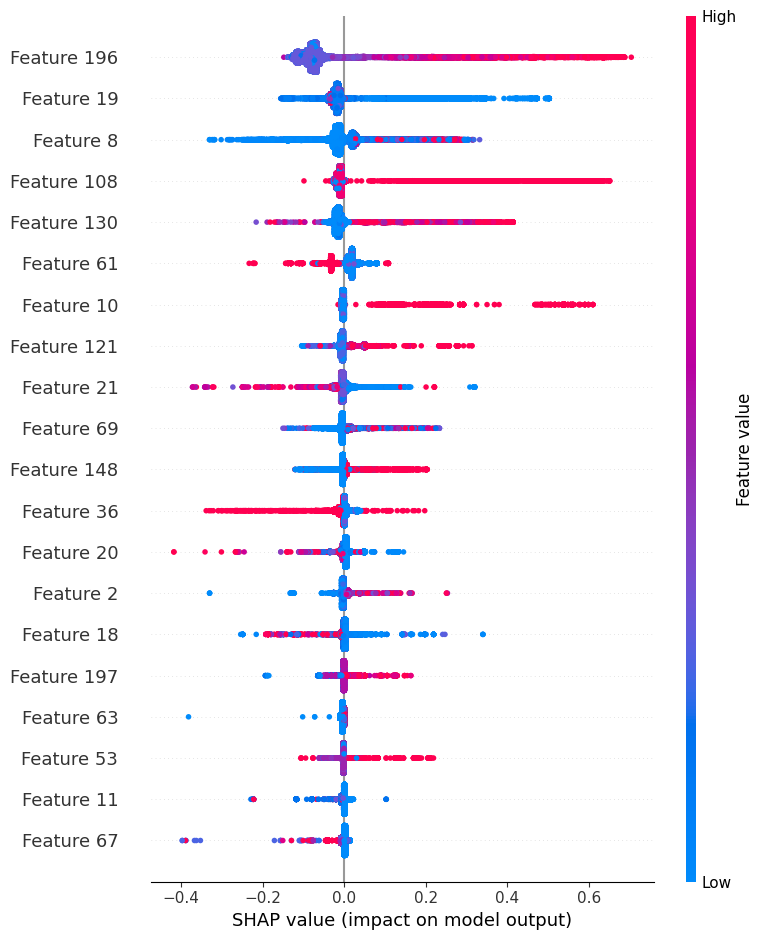

In [44]:
model = best_pipeline.named_steps['model']
X_train_transformed = best_pipeline[:-1].transform(X_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values[1], X_train_transformed)

# MLFLOW TRACKING

In [ ]:
# !pip install dagshub mlflow

In [76]:
# import dagshub
# dagshub.init(repo_owner='gkuch22', repo_name='ml-hw2-gkuch22', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=2d115990-9458-44e2-8a07-33c72d137ea2&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=04259f1de3ef7274bc067ef2b9b01f458972ab79864d7e723c0725f8d9c05f58




Accessing as gkuch22

Initialized MLflow to track repo "gkuch22/ml-hw2-gkuch22"

Repository gkuch22/ml-hw2-gkuch22 initialized!

In [39]:
experiment_name = "Decision_Tree_Training"
run_name = "Decision_Tree_Changed_HyperParameters"

In [40]:
import mlflow

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    mlflow.log_param("nunique_threshold", 0,8)
    mlflow.log_param("nan_threshold", 0.8)
    mlflow.log_param("categorical_threshold", 4)
    mlflow.log_param("a_encoder", "OneHotEncoder")
    mlflow.log_param("b_encoder", "WoeEncoder")
    mlflow.log_param("imputer_strategy", "mean")
    mlflow.log_param("scaler", "standard")
    
    mlflow.log_param("max_depth", 8)
    mlflow.log_param("min_samples_split", 7)
    mlflow.log_param("criterion", "gini")
    
    mlflow.log_param("model_type", "DecisionTree")
    
    logged_model = 'runs:/582efd80ff784537ac9bb1899d586167/cleaning_pipeline'
    cleaning = mlflow.sklearn.load_model(logged_model)
    
    logged_model = 'runs:/f5cd3ddfd3424719967852382ccce82c/engineering_pipeline'
    engineering = mlflow.sklearn.load_model(logged_model)
    
    nunique_thresholds = [0.8]
    nan_thresholds = [0.8]
    onehot_thresholds = [4]
    imputers = ['mean']
    scalers = {'standard': StandardScaler()}
    
    max_depths = [8]
    min_samples_splits = [7]
    criterions = ['gini']
    
    best_pipeline = None
    best_roc_auc = 0
    best_params = None
    
    for uniquet in nunique_thresholds:
        for nant in nan_thresholds:
            for oht in onehot_thresholds:
                for imputer in imputers:
                    for scaler_name, scaler in scalers.items():
                        for md, mss, crit in product(max_depths, min_samples_splits, criterions):
                            print()
                            print(f'uniquet={uniquet}, nt={nant}, oht={oht}, imputer={imputer}, scaler={scaler_name}')
                            print(f'md={md}, mss={mss}, crit={crit}')
                            
                            cleaning_pipeline = sk_clone(cleaning)
                            engineering_pipeline = sk_clone(engineering)
                            
                            cleaning_pipeline.named_steps['nunique_handler'].threshold = uniquet
                            cleaning_pipeline.named_steps['nan_handler'].threshold = nant
        
                            engineering_pipeline.named_steps['onehot_encoder'].threshold = oht
                            engineering_pipeline.named_steps['imputer'].strategy = imputer
    
                            model = DecisionTreeClassifier(max_depth=md, min_samples_split=mss,
                                                          criterion=crit, random_state=42) 
                            
                            pipeline = Pipeline(steps=[
                                ('cleaning', cleaning_pipeline),
                                ('engineering', engineering_pipeline),
                                ('model', model)
                            ])
                            
                            pipeline.fit(X_train, y_train)
    
                            y_train_pred = pipeline.predict(X_train)
                            y_train_prob = pipeline.predict_proba(X_train)[:, 1]

                            train_roc_auc = roc_auc_score(y_train, y_train_prob)
                            train_accuracy = accuracy_score(y_train, y_train_pred)
                            train_precision = precision_score(y_train, y_train_pred)
                            train_recall = recall_score(y_train, y_train_pred)
                            train_f1 = f1_score(y_train, y_train_pred)
                            print("TRAIN")
                            print(f"ROC AUC Score: {train_roc_auc}")
                            print(f"F1 Score: {train_f1}")
                            print(f"Recall: {train_recall}")
                            print(f"Precision: {train_precision}")
                            print(f"Accuracy: {train_accuracy}")
                            
                            
                            y_valid_pred = pipeline.predict(X_valid)
                            y_valid_prob = pipeline.predict_proba(X_valid)[:, 1]
                            
                            valid_roc_auc = roc_auc_score(y_valid, y_valid_prob)
                            valid_accuracy = accuracy_score(y_valid, y_valid_pred)
                            valid_precision = precision_score(y_valid, y_valid_pred)
                            valid_recall = recall_score(y_valid, y_valid_pred)
                            valid_f1 = f1_score(y_valid, y_valid_pred)
                            print("VALID")
                            print(f"ROC AUC Score: {valid_roc_auc}")
                            print(f"F1 Score: {valid_f1}")
                            print(f"Recall: {valid_recall}")
                            print(f"Precision: {valid_precision}")
                            print(f"Accuracy: {valid_accuracy}")
                            
                            if valid_roc_auc > best_roc_auc:
                                best_roc_auc = valid_roc_auc
                                best_pipeline = pipeline
                                best_params = (uniquet, nant, oht, imputer, scaler_name)

                            mlflow.log_metric("roc_auc/train", train_roc_auc)
                            mlflow.log_metric("roc_auc/valid", valid_roc_auc)
                            
                            mlflow.log_metric("f1/train", train_f1)
                            mlflow.log_metric("f1/valid", valid_f1)
                            
                            mlflow.log_metric("recall/train", train_recall)
                            mlflow.log_metric("recall/valid", valid_recall)
                            
                            mlflow.log_metric("precision/train", train_precision)
                            mlflow.log_metric("precision/valid", valid_precision)
                            
                            mlflow.log_metric("accuracy/train", train_accuracy)
                            mlflow.log_metric("accuracy/valid", valid_accuracy)

                            mlflow.sklearn.log_model(pipeline, "model")



uniquet=0.8, nt=0.8, oht=4, imputer=mean, scaler=standard
md=8, mss=7, crit=gini
TRAIN
ROC AUC Score: 0.8953793176948288
F1 Score: 0.7268085106382979
Recall: 0.6173143974827792
Precision: 0.8835199610516066
Accuracy: 0.8873800433391806
VALID
ROC AUC Score: 0.80296174571426
F1 Score: 0.5388429752066116
Recall: 0.3972966984267671
Precision: 0.8370681605975724
Accuracy: 0.823427881019504


2025/04/23 20:12:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Decision_Tree_Changed_HyperParameters at: https://dagshub.com/gkuch22/ml-hw2-gkuch22.mlflow/#/experiments/1/runs/b443ddc487684e0a9fca4b0ab7cf8b4f
🧪 View experiment at: https://dagshub.com/gkuch22/ml-hw2-gkuch22.mlflow/#/experiments/1
